<a href="https://colab.research.google.com/github/Mateusz0W/Inflation-Prediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
def load_gus_data(filename,pointer):
  data = pd.read_csv(filename,encoding="cp1250", sep=";")
  data= data.drop(columns=["Nazwa zmiennej","Jednostka terytorialna","Flaga","Unnamed: 7","Unnamed: 8"])
  data['Wartość'] = data['Wartość'].str.replace(',', '.').astype(float)
  data =data[data['Sposób prezentacji'].isin([pointer])]
  return data

def get_input_and_target(data,range1,range2,step):
  data = np.array(data[data['Rok'].between(range1,range2,inclusive='both')]['Wartość'])
  data_set = [(data[i:i+step],data[i+step]) for i in range(len(data) - step)]
  X, y =zip(*data_set)
  return np.array(X),np.array(y)

def split_data(X,y,test_size):
  split_index = int(len(X) * (1-test_size))
  X_train, y_train = X[:split_index], y[:split_index]
  X_test, y_test = X[split_index:], y[split_index:]
  return X_train, X_test, y_train, y_test

def plot_inflation(start_year,end_year,filename,pointer):
  data = load_gus_data(filename,pointer)
  data = data[data['Rok'].between(start_year,end_year,inclusive='both')]
  plt.plot(data['Rok'],data['Wartość'],color='green')
  plt.xlabel('Rok')
  plt.ylabel('Wartość')
  plt.title(f'Zmiana inflacji w latach {start_year} - {end_year}')
  plt.grid(True)
  plt.show()

def plot_predicted_inflation(y,y_pred,year):
  plt.plot(np.arange(1,len(y)+1),y,label='prawdziwa wartość',marker='o')
  plt.plot(np.arange(1,len(y_pred)+1),y_pred,label='przewidywana wartość',marker='o',color='red')
  plt.xlabel('Miesiąc')
  plt.ylabel('Wartość')
  plt.title(f'Zmiana inflacji w {year}')
  plt.legend()
  plt.grid(True)
  plt.show()


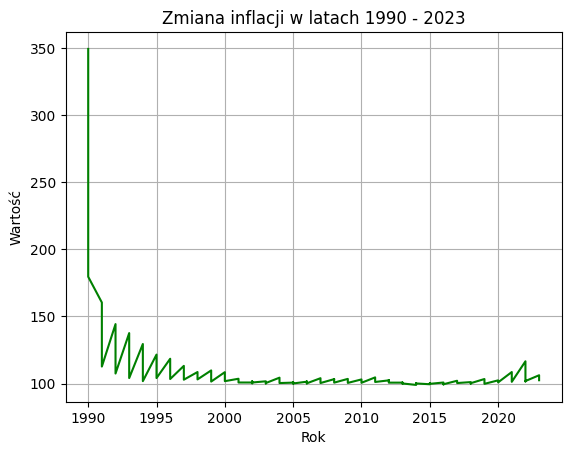

In [ ]:
filename= 'miesiecznewskaznikicentowarowiuslugkonsumpcyjnychod1982roku_3.csv'
pointer = 'Grudzień poprzedniego roku = 100'
start_year = 1990
end_year = 2023
step =12
plot_inflation(start_year,end_year,filename,pointer)

In [ ]:
data = load_gus_data(filename,pointer)
X, y =get_input_and_target(data,start_year,end_year,step)
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.3)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = MLPRegressor(solver='adam',hidden_layer_sizes=(10,10,10), max_iter = 2_000, tol = 0.001, activation = 'identity')
model.fit(X_train, y_train)
model.score(X_train,y_train)

0.7773254842162877

In [ ]:
model.score(X_test,y_test)

0.8802798424381709

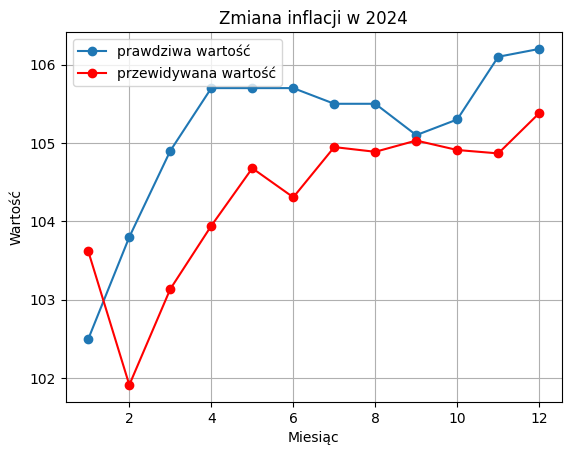

In [ ]:
data = np.array(data[data['Rok'].between(2023,2024,inclusive = 'both')]['Wartość'])
y = []
y_pred = []
for i in range(12):
  X = scaler.transform(np.array(data[i:i+12].reshape(1,-1)))
  y.append(data[i+12])
  y_pred.append(model.predict(X))
plot_predicted_inflation(y,y_pred,2024)


In [ ]:
print('y= ',y)
print('y_pred= ',y_pred)

y=  [np.float64(102.5), np.float64(103.8), np.float64(104.9), np.float64(105.7), np.float64(105.7), np.float64(105.7), np.float64(105.5), np.float64(105.5), np.float64(105.1), np.float64(105.3), np.float64(106.1), np.float64(106.2)]
y_pred=  [array([103.61623403]), array([101.91278294]), array([103.13643974]), array([103.94310221]), array([104.67789663]), array([104.30686479]), array([104.9475042]), array([104.88725516]), array([105.03083904]), array([104.91024735]), array([104.86689808]), array([105.38026573])]


In [ ]:
print('MSE = ',metrics.mean_squared_error(y,y_pred))



MSE =  1.4183187584981543
